Imports

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



Load Data

In [224]:


df = pd.read_csv("C:\\Users\\jonga\\Downloads\\regression_features(in).csv")
print("Dataset shape:", df.shape)
df.head()



Dataset shape: (206209, 14)


,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,reorder_ratio,mean_days_between_orders,last_order_recency,avg_basket_size,mean_days_last3,avg_basket_size_last3,total_orders_log
0,1,2550362,10,4,8,30,10,0.694915,18.542374,30,5.900000,14.666667,7.000000,2.397895
1,2,839880,14,3,10,13,14,0.476923,14.902564,13,13.928571,23.666666,14.666667,2.708050
2,3,1402502,12,1,15,15,12,0.625000,10.181818,15,7.333333,14.333333,5.666667,2.564949
3,4,2557754,5,5,13,0,5,0.055556,11.944445,0,3.600000,12.000000,4.000000,1.791759
4,5,157374,4,1,18,19,4,0.378378,10.189189,19,9.250000,13.333333,8.666667,1.609438


Target Engineering (Proxy Target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   206209 non-null  int64  
 1   order_id                  206209 non-null  int64  
 2   order_number              206209 non-null  int64  
 3   order_dow                 206209 non-null  int64  
 4   order_hour_of_day         206209 non-null  int64  
 5   days_since_prior_order    206209 non-null  int64  
 6   total_orders              206209 non-null  int64  
 7   reorder_ratio             206209 non-null  float64
 8   mean_days_between_orders  206209 non-null  float64
 9   last_order_recency        206209 non-null  int64  
 10  avg_basket_size           206209 non-null  float64
 11  mean_days_last3           206209 non-null  float64
 12  avg_basket_size_last3     206209 non-null  float64
 13  total_orders_log          206209 non-null  f

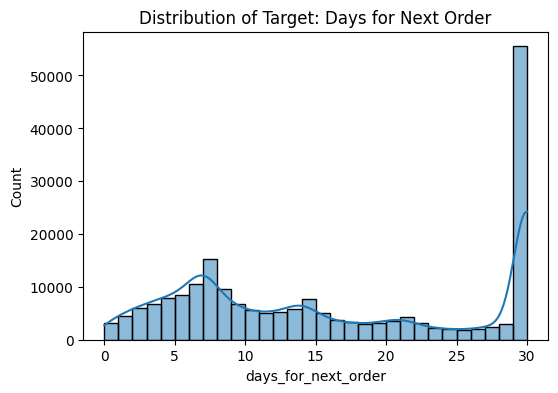

In [ ]:

df.info()
df.describe().T

df["days_for_next_order"] = df["days_since_prior_order"].fillna(
    df["days_since_prior_order"].median()
)

plt.figure(figsize=(6,4))
sns.histplot(df["days_for_next_order"], bins=30, kde=True)
plt.title("Distribution of Target: Days for Next Order")
plt.show()



Missing Values Analysis and Correlation Analysis

Series([], dtype: int64)


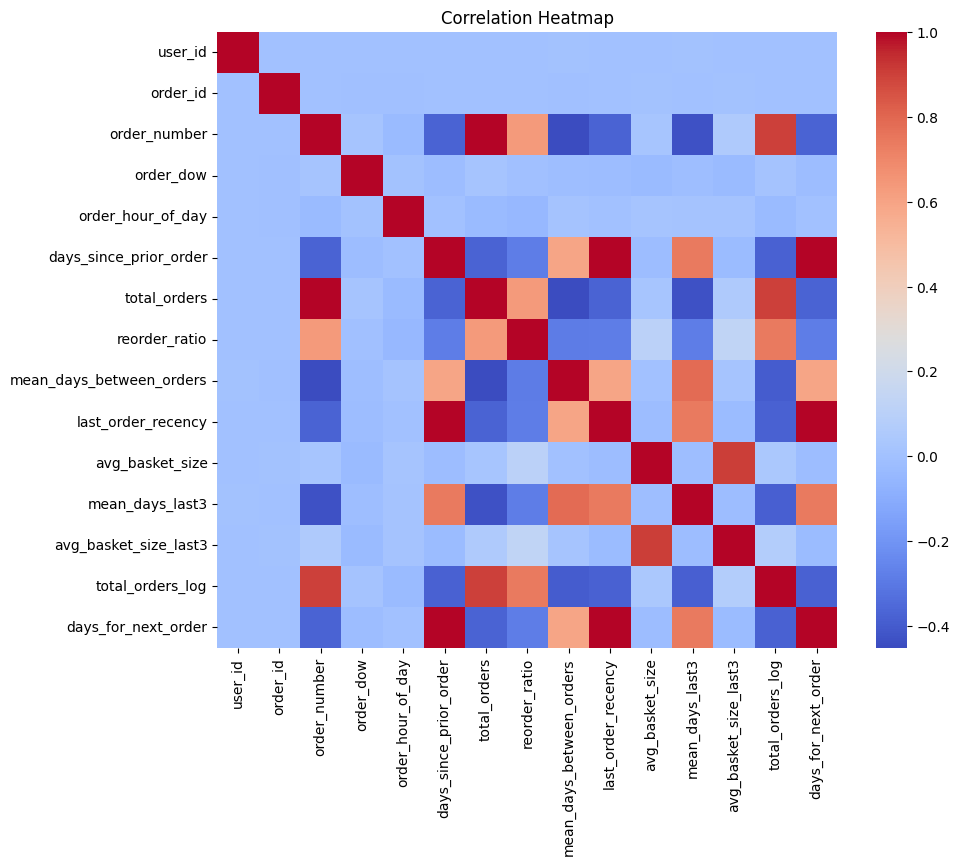

In [ ]:

missing = df.isna().sum().sort_values(ascending=False)
print(missing[missing > 0])

plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()



 Target Split and Train/Test Split

In [ ]:




target = "days_for_next_order"
drop_cols = [target, "order_number"]

X = df.drop(columns=drop_cols)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)



X shape: (206209, 13)
y shape: (206209,)
Train size: (164967, 13)
Test size: (41242, 13)


Preprocessing & Models (Pipelines)

In [ ]:





numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="drop"
)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        random_state=42
    )
}

pipelines = {
    name: Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    for name, model in models.items()
}



Training and Evaluation

In [ ]:

results = {}

for name, pipe in pipelines.items():
    print("Training:", name)
    pipe.fit(X_train, y_train)

    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    results[name] = {
        "Train_MAE": mean_absolute_error(y_train, train_preds),
        "Train_RMSE": np.sqrt(mean_squared_error(y_train, train_preds)),
        "Train_R2": r2_score(y_train, train_preds),
        "Test_MAE": mean_absolute_error(y_test, test_preds),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, test_preds)),
        "Test_R2": r2_score(y_test, test_preds)
    }

results_df = pd.DataFrame(results).T
results_df



Training: Linear Regression
Training: Ridge Regression
Training: Lasso Regression
Training: Random Forest
Training: Gradient Boosting


,Train_MAE,Train_RMSE,Train_R2,Test_MAE,Test_RMSE,Test_R2
Linear Regression,1.114332e-14,1.423582e-14,1.000000,1.111840e-14,1.434024e-14,1.000000
Ridge Regression,3.691860e-05,4.777977e-05,1.000000,3.710338e-05,4.793914e-05,1.000000
Lasso Regression,9.014365e-03,1.000000e-02,0.999999,9.020057e-03,1.000904e-02,0.999999
Random Forest,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,1.000000
Gradient Boosting,3.536396e-05,7.433772e-05,1.000000,3.542861e-05,7.418078e-05,1.000000


 Model Comparison Visualization

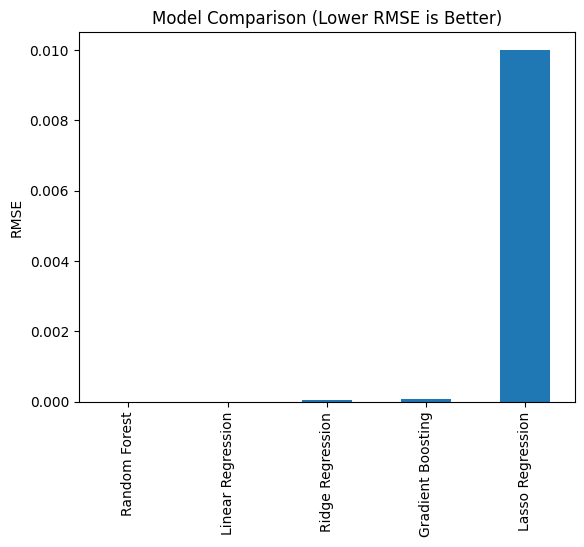

In [ ]:

results_df[["Test_RMSE"]].sort_values("Test_RMSE").plot(kind="bar", legend=False)
plt.title("Model Comparison (Lower RMSE is Better)")
plt.ylabel("RMSE")
plt.show()



Residual Analysis (Best Model) and Cross-Validation

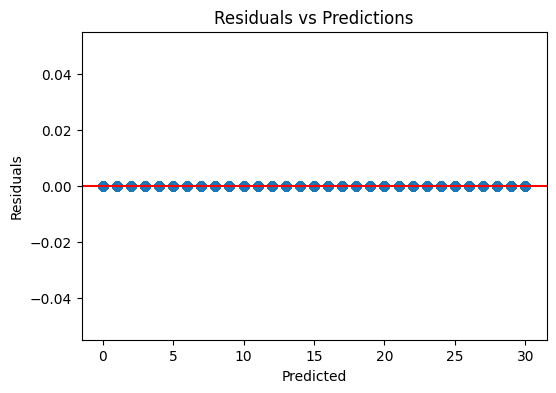

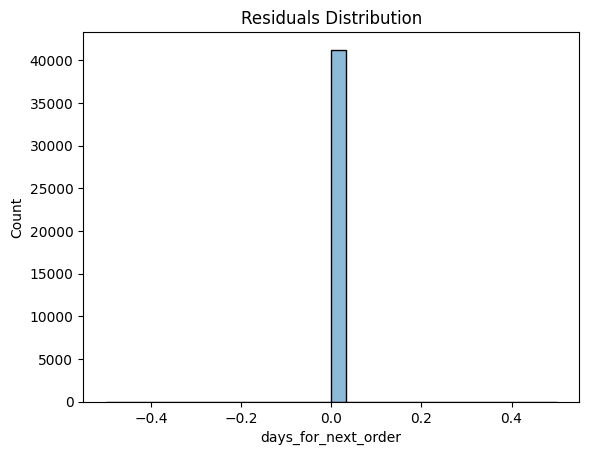

CV RMSE scores: [0. 0. 0. 0. 0.]
Mean CV RMSE: -0.0


In [ ]:


best_model_name = results_df["Test_RMSE"].idxmin()
best_pipeline = pipelines[best_model_name]

preds = best_pipeline.predict(X_test)
residuals = y_test - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals)
plt.axhline(0, color="red")
plt.title("Residuals vs Predictions")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.show()


cv_scores = cross_val_score(
    best_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print("CV RMSE scores:", -cv_scores)
print("Mean CV RMSE:", -cv_scores.mean())


